# Uncertainty guided virtual screening of small molecules
This tutorial describes the process to perform uncertainty guided virtual screening by utilizing a deterministic pre-trained predictor model. We utlize the active subspace approach to enable the uncertainty quantification of the pre-trained predictor model. 

![alt text](image.png)

1. The UQ guided virtual screening pipeline takes the pre-trained property predictor and enables the uncertainty quantification by the active subspace (AS) around the pre-trained model weights. 
2. Next, the properties of the candidate moleules are predicted in Bayesian inference manner which also provides the uncertainty in the predictions. 
3. Finally, we perform screening based on the predictions and the corresponding uncertainties. By removing samples with higher uncertainty (lower confidence) in predicted class-labels, we want to improve the hit rate (success rate of selecting active samples in the screened pool of candidates) of the virtual screening process.

# Train the predictor model (Step 0)
We first train a predictor model for molecular prorperty DRD2. Note this prediction network provides a deterministic prediction of molecular activity against DRD2.

In [ ]:
!python train_surrogate.py --prop_name=DRD2

# Enable UQ for the predictor model (Step 1)
The trained predictor model does not provide the uncertainty in its prediction. To perform UQ through AS, first we need to construct the active subspace around the pre-trained model weights, and learn the posterior distribution over the active subspace parameters by variational inference technique. Later this learned/approximated posterior distribution is used in Bayesian inference for the molecules during screening.

In [ ]:
!python run_active_subspace_construction.py --prop_name=DRD2 --AS_dim=10
!python run_vi_training.py --prop_name=DRD2 --AS_dim=10

# Perform prediction via Bayesian inference using the learned AS posterior (Step 2)

In [ ]:
%%bash
for i in {0...4}; do
    python run_screening_AS_pred.py --prop_name=DRD2 --AS_dim=10 --trial=$i --num_models=10
done

# Running UQ guided virtual screening (Step 3)
We utilize the Bayesian predictions and the quanitfied uncertainty in the predictions done in the previous step to screen for active samples by first selecting molecules based on larger Bayesian predictions followed by removal of most uncertain samples with reference to a threhsold. This process is repeated for 5 trials. Next, we visualize the standard deviation of hit rate across 5 trials of each property.

In [2]:
import numpy as np
from tdc import Oracle

In [3]:
def get_oracle(prop_name):
  oracle = Oracle(name = prop_name)
  return oracle

def get_hit_rate(prop_name, AS_dim_list, num_models_list):
  oracle = get_oracle(prop_name)

  thr_list = np.arange(101)
  top_k = 50 # 55 in total
  hit_rate = np.zeros((len(AS_dim_list),len(num_models_list),5, len(thr_list)+2))
  num_hits = np.zeros((len(AS_dim_list),len(num_models_list),5, len(thr_list)+2))
  for idx_AS, AS_dim in enumerate(AS_dim_list):
    for idx_num_models, num_models in enumerate(num_models_list):
      for trial in range(5):
        data = np.load(f'./log/{prop_name.lower()}/basic/AS/{prop_name}_screening_trial_{trial}_AS_dim_{AS_dim}_num_models_{num_models}.npz')
        sorted_idx = np.argsort(-data['PTM_pred'].reshape(-1))
        true_labels = 1.0*(np.array(oracle(data['cands_list'].tolist()))>=0.5)
        # top_k = int(sum(true_labels))
        hit_rate[idx_AS,idx_num_models,trial,0]= true_labels[sorted_idx[:top_k]].mean()
        num_hits[idx_AS,idx_num_models,trial,0]= true_labels[sorted_idx[:top_k]].sum()
        for thr in thr_list:
          sorted_idx = np.argsort(-data['BMA_preds'].reshape(-1))
          hit_rate[idx_AS,idx_num_models, trial,1]= true_labels[sorted_idx[:top_k]].mean()
          num_hits[idx_AS,idx_num_models, trial,1]= true_labels[sorted_idx[:top_k]].sum()
          unc_thr = np.percentile(data['BMA_unc'][sorted_idx[:top_k]], thr)

          screened_idx = data['BMA_unc'][sorted_idx[:top_k]] <= unc_thr
          hit_rate[idx_AS,idx_num_models, trial,thr+2]= true_labels[sorted_idx[:top_k]][screened_idx].mean()
          num_hits[idx_AS,idx_num_models, trial,thr+2]= true_labels[sorted_idx[:top_k]][screened_idx].sum()

  return hit_rate

In [ ]:
AS_dim_list = [10]
num_models_list = [10]
thr_list = np.arange(101)
prop_name = 'DRD2'
hit_rate = get_hit_rate('DRD2', AS_dim_list, num_models_list)
hit_rate_std = hit_rate.std(axis=2)[:,:,2:]

Found local copy...


In [ ]:
import matplotlib.pyplot as plt

def plot_results_view1(hit_rate, AS_dim_list, num_models_list, thr_list, prop_name):
  
  fig, axes = plt.subplots(1, 1, figsize=(6, 4), dpi = 300)

  # Assuming hit_rate_std has shape (len(AS_dim_list), len(num_models_list), len(thr_list))
  for i in range(len(AS_dim_list)):
      for j in range(len(num_models_list)):
          row = i // 2
          col = i % 2
          ax = axes[row, col]

          ax.plot(100-thr_list,hit_rate_std[i, j], label=f"num_models={num_models_list[j]}")

          ax.set_title(f"AS dim={AS_dim_list[i]}")
          ax.set_xlabel("Screening Threshold")
          ax.set_ylabel("Hit Rate Standard Deviation")
          ax.legend(loc = 'upper left')
          ax.set_ylim(-0.005, hit_rate_std.max()*1.05)

  plt.suptitle(f"Screening for {prop_name}")
  plt.tight_layout()
  plt.show()





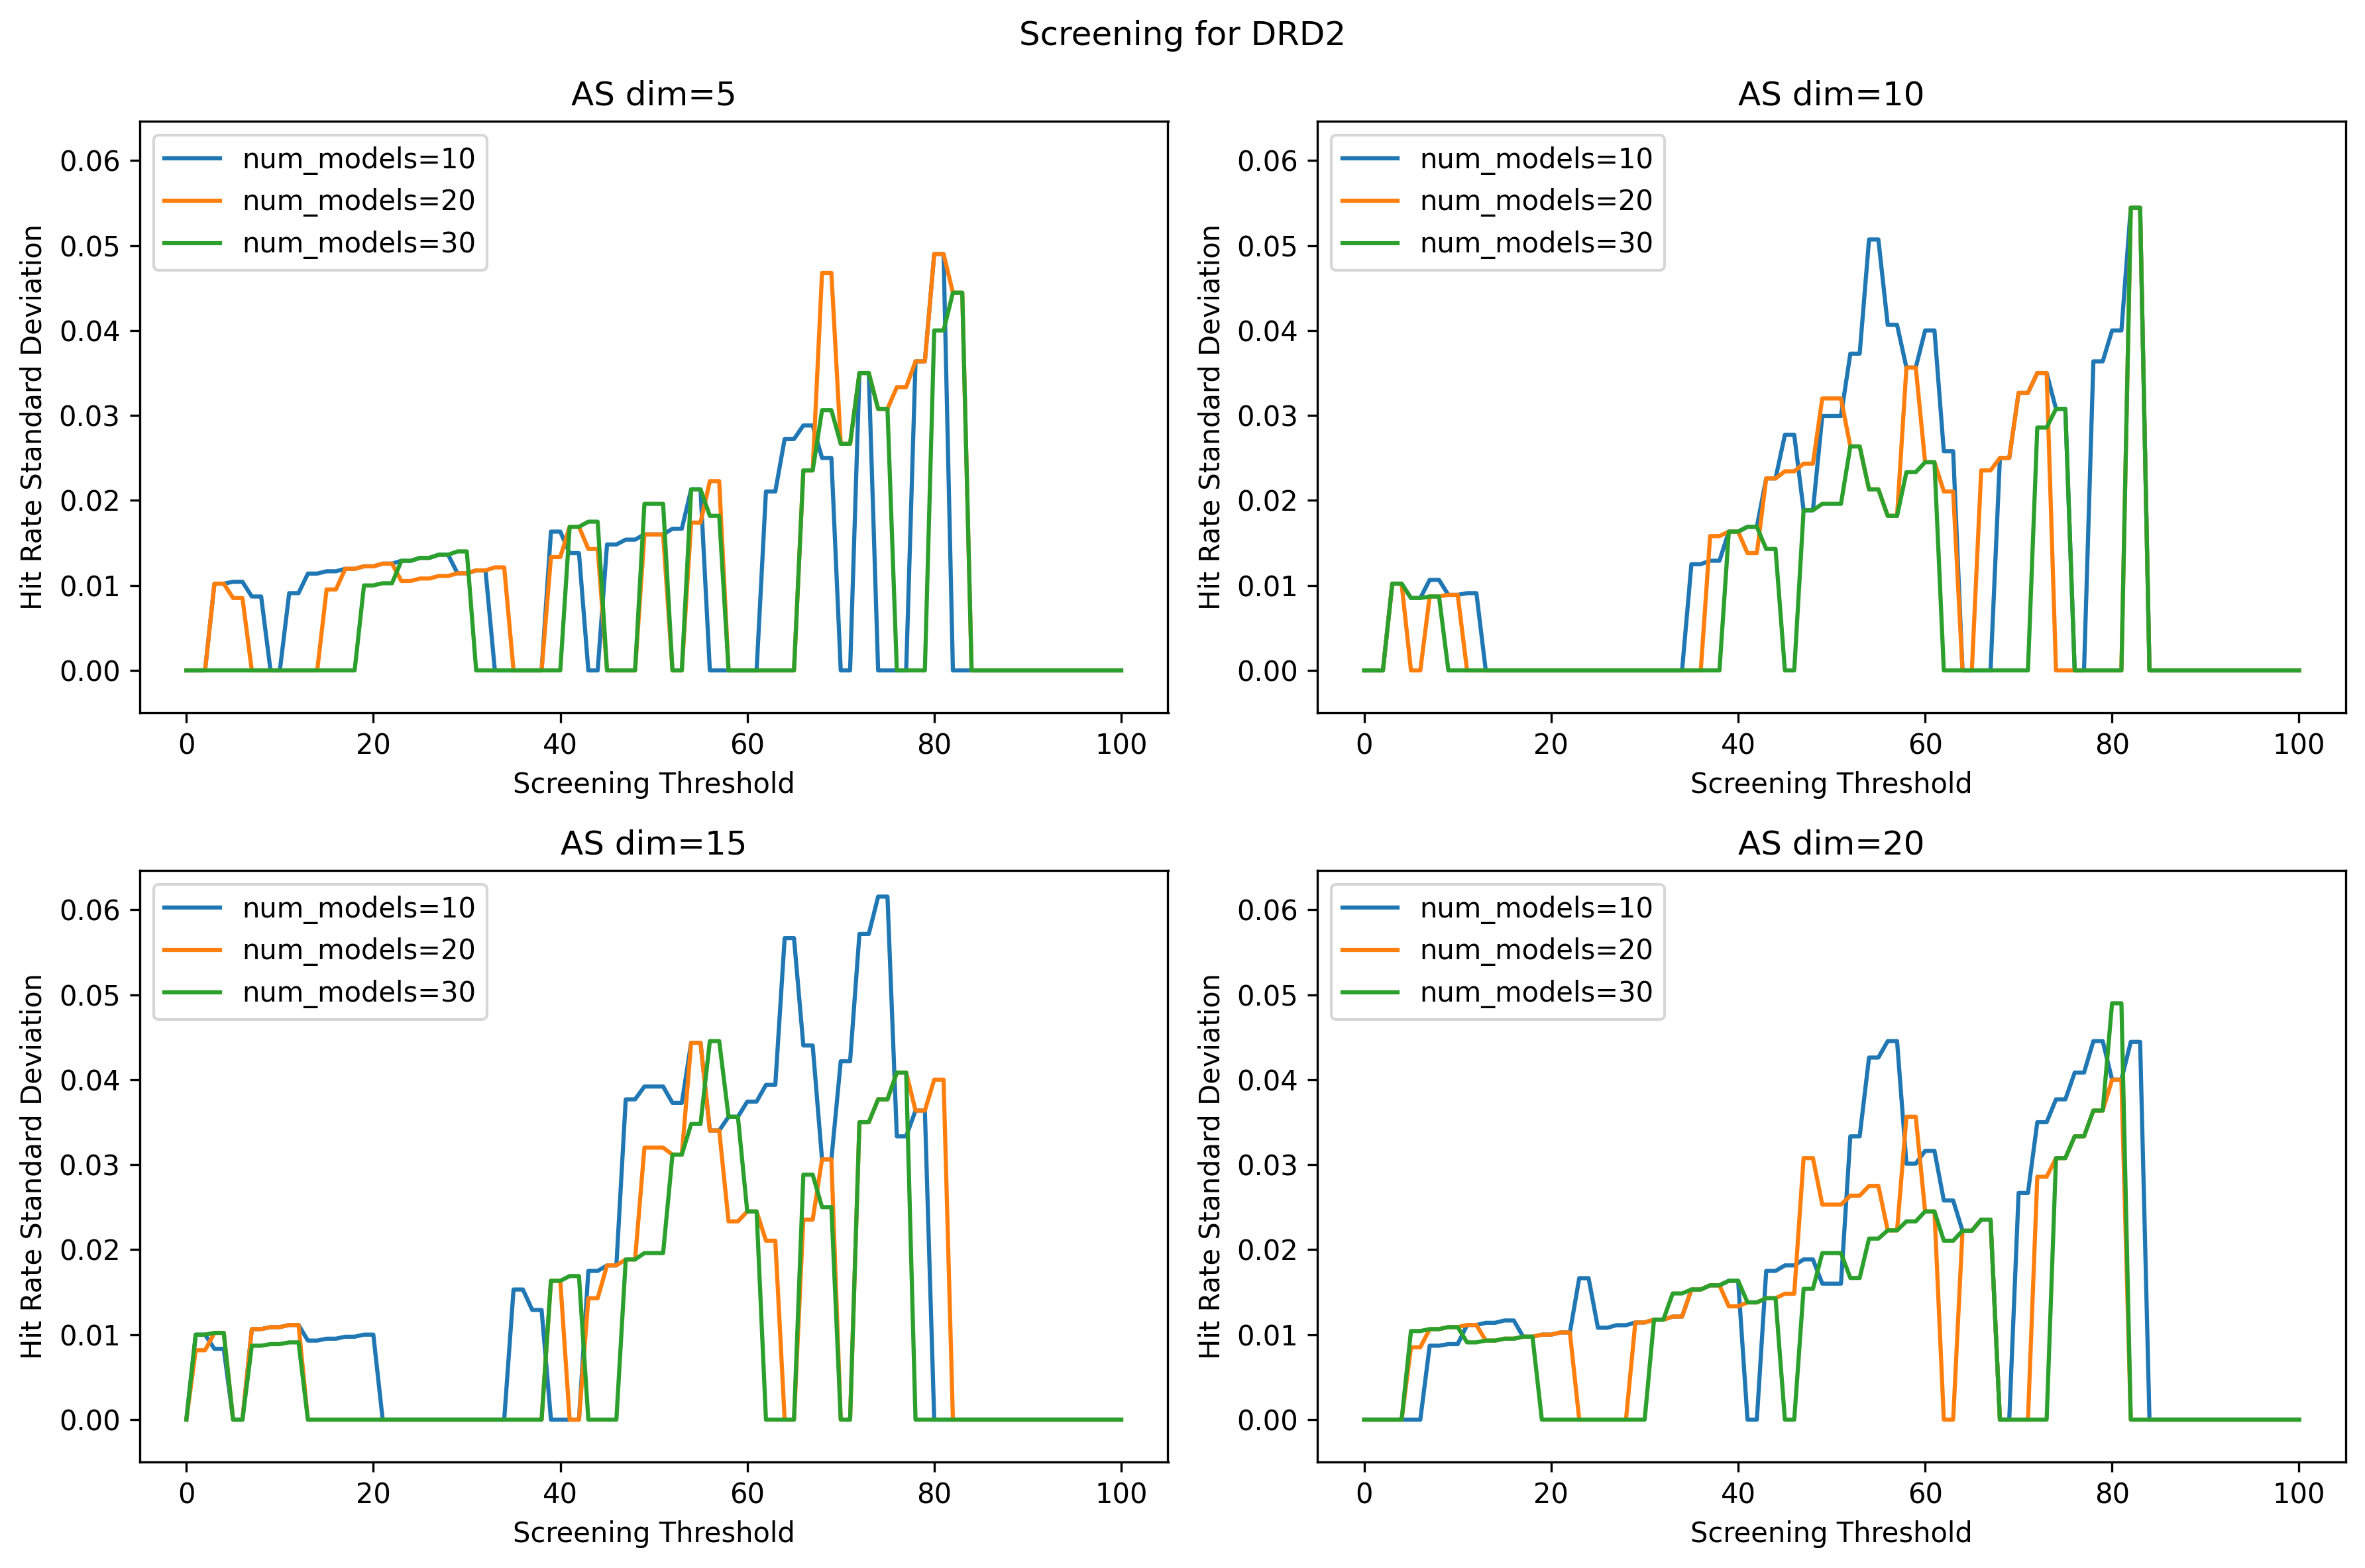

In [6]:
plot_results_view1(hit_rate_std, AS_dim_list, num_models_list, thr_list, prop_name)